In [6]:
import matplotlib.pyplot as plt

In [1]:
from numba import cuda
 
@cuda.jit(device=True)
def compute_point(c):
    i = -1
    z = complex(0, 0)
    while abs(z) < 2:
        i += 1
        if i == 255:
            break
        z = z**2 + c
    return 255 - (255 * i)

In [2]:
@cuda.jit
def compute_all_points(startx, starty, endx, endy, size, img_array):
    x, y = cuda.grid(2)
    if x >= img_array.shape[0] or y >= img_array.shape[1]:
        return
    mandel_x = (end[0] - startx)*(x/size) + startx
    mandel_y = (end[1] - starty)*(y/size) + starty
    img_array[y, x] = compute_point(complex(mandel_x, mandel_y))

In [3]:
from math import ceil
import numpy as np
from PIL import Image
 
size = 2000
start = -1.5, -1.3
end = 0.5, 1.3
 
img_array = np.empty((size, size), dtype=np.uint8)
threads_per_block_2d = 16, 16
blocks_per_grid_2d = ceil(size / 16), ceil(size / 16)
 
compute_all_points[blocks_per_grid_2d,
  threads_per_block_2d](start[0], start[1], end[0], end[1],
  size, img_array)

c:\Users\wicaks72\AppData\Local\anaconda3\envs\cuda\lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [4]:
img = Image.fromarray(img_array, mode="P")

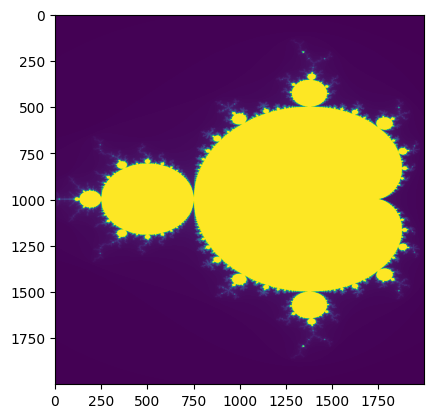

In [7]:
plt.imshow(img_array)

In [9]:
%%timeit
compute_all_points[blocks_per_grid_2d, threads_per_block_2d](
    start[0],
    start[1],
    end[0],
    end[1],
    size,
    img_array,
)

330 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
3.64 * 1e12 / 1e6

3640000.0

In [22]:
def compute_point(c, max_iter=200):
    num_iter = -1
    z = complex(0, 0)
    while abs(z) < 2:
        num_iter += 1
        if num_iter == max_iter:
            break
        z = z**2 + c
    return 255 - (255 * num_iter) // max_iter

In [23]:
from numba import jit
 
compute_point_numba = jit()(compute_point)

C:\Users\wicaks72\AppData\Local\Temp\ipykernel_24532\2843802308.py:3: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  compute_point_numba = jit()(compute_point)


In [24]:
def do_all(size, start, end, img_array, compute_fun):
    startx, starty = start
    endx, endy = end
    for xp in range(size):
        x = (endx - startx)*(xp/size) + startx  # precision issues
        for yp in range(size):
            y = (endy - starty)*(yp/size) + starty  # precision issues
            img_array[yp, xp] = compute_fun(complex(x,y))

In [25]:
size = 2000
start = -1.5, -1.3
end = 0.5, 1.3
 
img_array = np.empty((size, size), dtype=np.uint8)

In [26]:
 %timeit do_all(size, start, end, img_array, compute_point)

59.1 s ± 558 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
do_all(size, start, end, img_array, compute_point_numba)

In [28]:
 %timeit do_all(size, start, end, img_array, compute_point_numba)

2.93 s ± 61.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
from numba import prange
 
@jit(nopython=True,parallel=True,nogil=True)
def pdo_all(size, start, end, img_array, compute_fun):
    startx, starty = start
    endx, endy = end
    for xp in prange(size):
        x = (endx - startx)*(xp/size) + startx
        for yp in range(size):
            y = (endy - starty)*(yp/size) + starty
            b = compute_fun(complex(x, y))
            img_array[yp, xp] = b

In [30]:
pdo_all(size, start, end, img_array, compute_point_numba)

In [31]:
%timeit pdo_all(size, start, end, img_array, compute_point_numba)

202 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
